# How to Create a Risk-On vs Risk-Off Stock Market Dashboard in Python: Part 5
By Cordell L. Tanny, CFA, FRM, FDP

March 11, 2024

As stated in the article, a lot of work went into this. I would love for you to share the article!
Also check out https://trendprophets.com to see how I can give you long-term investment results at a very low cost.
Subscribe to the Digital Hub newsletter for more free code!
https://dh-insights.com


In [1]:
# needed imports and installs
!pip install scikit-learn-extra
!pip install pandas-ta
!pip install dtaidistance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta
from scipy.stats import norm
from datetime import datetime
import yfinance as yf
from itertools import combinations
import pickle
from statsmodels.tsa.stattools import ccf
import pandas_ta as ta
from sklearn.manifold import MDS
from sklearn_extra.cluster import KMedoids
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import adjusted_rand_score
from joblib import Parallel, delayed
from dtaidistance import dtw
import scipy.stats as stats

sns.set_theme(
    rc={
        "figure.facecolor": "#051239",  # Outside graph area background color
        # "axes.facecolor": "#051239",   # Inside graph area background color
        "axes.labelcolor": "white",  # Font color for labels
        "axes.titlecolor": "white",  # Font color for titles
        "text.color": "white",  # Font color for text
    }
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=d04e7d8c60b98c007b9413e8c8018426f59549dbd0d8de0378a0842dc5bee0b4
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.4 MB/s eta 0:00:00


## Functions

In [2]:
def get_prices_yf(ticker, start_date, end_date):
    """
    This function keeps all pricing data from yahoo finance for use in technical analysis functions.
    :param ticker: string
    :param start_date: string YYYY-MM-DD
    :param end_date:string YYYY-MM-DD
    :return: pd.DataFrame
    """
    df = yf.download(ticker, start=start_date, end=end_date)
    return df


# function to calculate the ADX line components using pandas_ta for a given price series
def calculate_adx_components(prices_df, adx_period=14):
    """
    Calculate the ADX line components using pandas_ta for a given price series.
    The adx line shows a trend is strong when the reading is over 25.
    Below 20, there is no trend.
    The difference between the DMN and DMP lines tells you if the trend id currently positive
    or negative.
    https://school.stockcharts.com/doku.php?id=technical_indicators:average_directional_index_adx

    Parameters:
    prices_df (DataFrame): DataFrame with price data.
    adx_period (int): Period for ADX calculation.

    Returns:
    DataFrame: DataFrame with ADX_14 and the difference between DMP and DMN.
    """
    # Calculate the ADX line components
    adx_components = prices_df.ta.adx(adx_period)
    adx_components['adx_diff'] = adx_components['DMP_14'] - adx_components['DMN_14']

    return adx_components[['ADX_14', 'adx_diff']].dropna()


# create a function that returns the MACD historgram value from pandas_ta
def calculate_macd_histogram(prices_df, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculate the MACD histogram using pandas_ta for a given price series.

    Parameters:
    prices_df (DataFrame): DataFrame with price data.
    fast_period (int): Period for the fast EMA.
    slow_period (int): Period for the slow EMA.
    signal_period (int): Period for the signal line.

    Returns:
    DataFrame: DataFrame with MACD histogram values.
    """
    # Calculate the MACD histogram
    macd_histogram = prices_df.ta.macd(fast_period, slow_period, signal_period, append=False)

    return macd_histogram['MACDh_12_26_9'].to_frame(name='MACD_hist').dropna()


def resample_prices(prices_df, frequency='W'):
    """
    Resample daily stock prices to weekly or monthly depending on the frequency.

    Parameters:
    prices_df (DataFrame): DataFrame with daily price data.
    frequency (str): Resampling frequency ('W' for weekly, 'M' for monthly).

    Returns:
    DataFrame: DataFrame with resampled prices.
    """

    prices_df.index = pd.to_datetime(prices_df.index)

    if frequency == 'W':
        # Adjust resampling to ensure the week ends on Friday
        resampled_prices = prices_df.resample('W-FRI').last()
    elif frequency == 'M':
        # Resample to the last day of the month
        resampled_prices = prices_df.resample('M').last()

    return resampled_prices.dropna()


# function to calculate the rolling volatility of stock prices over the supplied window
def rolling_volatility(returns_df, window=12, frequency='W', annualize=True):
    """
    Calculate rolling volatility for a given price series.

    Parameters:
    prices_df (DataFrame): DataFrame with price data.
    window (int): Rolling window size.

    Returns:
    Series: Series with rolling volatility values.
    """

    # if there are more than one column in the prices_df, use the column 'Adj Close'
    if returns_df.shape[1] > 1:
        col = 'Adj Close'

        # Calculate the rolling volatility
        volatility = returns_df[col].pct_change().rolling(window).std()

    else:
        volatility = returns_df.pct_change().rolling(window).std()

    if annualize:
        if frequency == 'W':
            periods_per_year = 52
        elif frequency == 'M':
            periods_per_year = 12

        volatility = volatility * np.sqrt(periods_per_year)

    return volatility.to_frame(name=f'rolling_vol_{window}').dropna()


# function that takes prices, converts to rolling returns over a specified window and scales by the rolling volatility
def scale_returns_by_volatility(prices_df, window=12, frequency='W', annualize=True):
    """
    Scale returns by volatility for a given price series.

    Parameters:
    prices_df (DataFrame): DataFrame with price data.
    window (int): Rolling window size.
    frequency (str): Resampling frequency ('W' for weekly, 'M' for monthly).
    annualize (bool): Whether to annualize the volatility.

    Returns:
    DataFrame: DataFrame with scaled returns.
    """
    # Calculate the rolling volatility
    rolling_vol = rolling_volatility(prices_df, window, frequency, annualize).dropna()

    # Calculate the rolling returns
    if prices_df.shape[1] > 1:
        col = 'Adj Close'

        rolling_returns = prices_df[col].pct_change(window).dropna()

    else:
        rolling_returns = prices_df.pct_change(window).dropna()

    # Scale the rolling returns by the rolling volatility
    scaled_returns = rolling_returns.div(rolling_vol[f'rolling_vol_{window}'], axis=0)

    return scaled_returns.to_frame(name=f'scaled_returns_{window}').dropna()


# function to calculate the scale_returns_by_volatility for a list of tickers, returning a dataframe
def scale_multiple_tickers_by_volatility(tickers, start_date, end_date, window=12, frequency='W', annualize=True,
                                         relative=None):
    """
    Calculate scaled returns by volatility for a list of tickers.

    Parameters:
    tickers (list): List of tickers.
    start_date (str): Start date for the analysis.
    end_date (str): End date for the analysis.
    window (int): Rolling window size.
    frequency (str): Resampling frequency ('W' for weekly, 'M' for monthly).
    annualize (bool): Whether to annualize the volatility.
    relative (str): Ticker to use as a relative benchmark for relative performance. Default is None.

    Returns:
    DataFrame: DataFrame with scaled returns for each ticker.
    """
    # Initialize an empty DataFrame to store the scaled returns
    scaled_returns_df = pd.DataFrame()

    # Loop through each ticker and calculate the scaled returns
    for ticker in tickers:
        # Retrieve the prices
        prices = get_prices_yf(ticker, start_date, end_date)

        # Resample prices based on the specified frequency
        prices = resample_prices(prices, frequency)

        if relative:
            # retrieve the benchmark prices and calculate the relative performance
            benchmark_prices = get_prices_yf(relative, start_date, end_date)
            benchmark_prices = resample_prices(benchmark_prices, frequency)
            prices['Adj Close'] = prices['Adj Close'] / benchmark_prices['Adj Close']

        # Calculate the scaled returns by volatility
        scaled_returns = scale_returns_by_volatility(prices, window, frequency, annualize)

        # Append the scaled returns to the DataFrame
        scaled_returns_df = pd.concat([scaled_returns_df, scaled_returns], axis=1)

    # change the column names to match tickers
    scaled_returns_df.columns = tickers

    return scaled_returns_df.dropna()


# function to calculate the RSI for a given price series
def rsi(prices_df, period=14):
    """
    Calculate the Relative Strength Index (RSI) for a given price series.

    Parameters:
    prices_df (DataFrame): DataFrame with price data.
    period (int): Period for RSI calculation.

    Returns:
    DataFrame: DataFrame with RSI values.
    """
    # Calculate the RSI
    rsi = prices_df.ta.rsi(period)

    return rsi.to_frame(name='RSI').dropna()


def bollinger_bands(prices_df, period=20, std_dev=2):
    """
    Calculate the Bollinger Bands for a given price series.

    Parameters:
    prices_df (DataFrame): DataFrame with price data.
    period (int): Period for moving average calculation.
    std_dev (int): Standard deviation for the bands.

    Returns:
    DataFrame: DataFrame with Bollinger Bands.
    """
    # Calculate the Bollinger Bands
    bollinger_bands = prices_df.ta.bbands(length=period, std=std_dev)

    return bollinger_bands.dropna()


def reverse_column_order(df, n=5):
    """
    Reverse the order of the columns in a DataFrame and keep only the first n columns.

    Parameters:
    df (DataFrame): DataFrame to reverse.
    n (int): Number of columns to keep.

    Returns:
    DataFrame: DataFrame with reversed column order and only the first n columns.
    """
    # Reverse the order of the columns and keep only the first n columns
    reversed_df = df.iloc[:, ::-1].iloc[:, :n]

    return reversed_df


# function to calculate the Chaiking Money Flow (CMF) for a given price series
def chaikin_money_flow(prices_df, period=12):
    """
    Calculate the Chaikin Money Flow (CMF) for a given price series.

    Parameters:
    prices_df (DataFrame): DataFrame with price data.
    period (int): Period for CMF calculation.

    Returns:
    DataFrame: DataFrame with CMF values.
    """
    # Calculate the Chaikin Money Flow
    cmf = prices_df.ta.cmf(period)

    return cmf.to_frame(name='CMF').dropna()


# function to calculate the percentage price oscillator (PPO) for a given price series
def ppo(prices_df, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculate the Percentage Price Oscillator (PPO) for a given price series.

    Parameters:
    prices_df (DataFrame): DataFrame with price data.
    fast_period (int): Period for the fast EMA.
    slow_period (int): Period for the slow EMA.
    signal_period (int): Period for the signal line.

    Returns:
    DataFrame: DataFrame with PPO values.
    """
    # Calculate the PPO
    ppo = prices_df.ta.ppo(fast_period, slow_period, signal_period)

    return ppo.dropna()


def ppo_histogram(prices_df, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculate the PPO histogram for a given price series.

    Parameters:
    prices_df (DataFrame): DataFrame with price data.
    fast_period (int): Period for the fast EMA.
    slow_period (int): Period for the slow EMA.
    signal_period (int): Period for the signal line.

    Returns:
    DataFrame: DataFrame with PPO histogram values.
    """
    # Calculate the PPO histogram
    ppo_histogram = prices_df.ta.ppo(fast_period, slow_period, signal_period, append=False)

    return ppo_histogram['PPOh_12_26_9'].to_frame(name='PPO_hist').dropna()


# function to calculate rolling downside deviation over a rolling window
def rolling_downside_deviation(returns_df, window=12, frequency='W', annualize=True):
    """
    Calculate rolling downside deviation for a given returns series.

    Parameters:
    returns_df (DataFrame): DataFrame with returns data.
    window (int): Rolling window size.
    frequency (str): Resampling frequency ('W' for weekly, 'M' for monthly).
    annualize (bool): Whether to annualize the downside deviation.

    Returns:
    Series: Series with rolling downside deviation values.
    """
    if returns_df.shape[1] > 1:
        col = 'Adj Close'

    # Calculate the rolling downside deviation
    downside_deviation = returns_df[col].pct_change().rolling(window).apply(lambda x: x[x < 0].std()).fillna(0)

    if annualize:
        if frequency == 'W':
            periods_per_year = 52
        elif frequency == 'M':
            periods_per_year = 12

        downside_deviation = downside_deviation * np.sqrt(periods_per_year)

    if isinstance(downside_deviation, pd.DataFrame):
        downside_deviation.columns = [f'rolling_dd_{window}']

    else:
        downside_deviation = downside_deviation.to_frame(name=f'rolling_dd_{window}')

    return downside_deviation.dropna()


def calculate_mass_index(prices_df, window=25):
    """
    Calculate the Mass Index for a given DataFrame and then take a rolling average
    of the results.

    The DataFrame should contain 'High' and 'Low' columns, which represent
    the high and low prices for the stock. The Mass Index is a volatility
    indicator that is designed to identify trend reversals by comparing the
    range between the high and the low prices.

    Parameters:
    df (pd.DataFrame): A DataFrame containing at least 'High' and 'Low' columns.
    window (int, optional): The size of the rolling window for the average. Default is 12.

    Returns:
    pd.Series: A Series where each value is the rolling average of the Mass Index.

    Raises:
    ValueError: If the input DataFrame does not contain 'High' and 'Low' columns.
    """
    # Ensure the DataFrame has 'High' and 'Low' columns
    if 'High' not in prices_df.columns or 'Low' not in prices_df.columns:
        raise ValueError("DataFrame must have 'High' and 'Low' columns")

    # Calculate the Mass Index for the entire DataFrame
    mass_index = ta.massi(prices_df['High'], prices_df['Low'])

    # Take a rolling average of the results
    mass_index_avg = mass_index.rolling(window).mean()

    return mass_index_avg.to_frame(name=f'mass_index_{window}').dropna()


# function to standardize the time series history of the technical indicators
def standardize_time_series(df):
    """
    Standardize the time series history of the technical indicators.

    Parameters:
    df (DataFrame): DataFrame with technical indicator values.

    Returns:
    DataFrame: DataFrame with standardized technical indicator values.
    """
    # Standardize the time series history of the technical indicators
    standardized_df = (df - df.mean()) / df.std()

    return standardized_df


def calculate_technical_indicators(tickers, start_date, end_date, standardize=True):
    """
    Calculate technical indicators for a list of tickers.

    Parameters:
    tickers (list): List of tickers.
    start_date (str): Start date for the analysis.
    end_date (str): End date for the analysis.

    Returns:
    dict: Dictionary with technical indicator DataFrames for each ticker.
    """

    # Initialize an empty dictionary to store the technical indicator DataFrames
    technical_indicators_dict = {}

    # Loop through each ticker and calculate the technical indicators
    for ticker in tickers:
        # Retrieve the prices
        prices = get_prices_yf(ticker, start_date, end_date)

        # change to weekly frequency, with the date set to the last Friday of the week
        prices = resample_prices(prices, 'W')

        # Calculate the technical indicators
        adx = calculate_adx_components(prices)
        macd = calculate_macd_histogram(prices)
        rolling_vol = rolling_volatility(prices)
        rsi_df = rsi(prices)
        bb = bollinger_bands(prices).iloc[:, -1]  # keep the last column only which is the BBP
        chaikin = chaikin_money_flow(prices)
        ppo_df = ppo_histogram(prices)
        dd = rolling_downside_deviation(prices)
        massi = calculate_mass_index(prices)
        scaled_returns = scale_returns_by_volatility(prices, window=12, frequency='W', annualize=True)

        # Merge the technical indicators into a single DataFrame
        dfs = [adx, macd, rolling_vol, rsi_df, bb, chaikin, ppo_df, dd, massi, scaled_returns]
        technical_indicators_df = dfs[0]
        for df in dfs[1:]:
            technical_indicators_df = technical_indicators_df.merge(df, left_index=True, right_index=True)

        # Standardize the time series history of the technical indicators
        if standardize:
            technical_indicators_df = standardize_time_series(technical_indicators_df)

        # Store the DataFrame in the dictionary
        technical_indicators_dict[ticker] = technical_indicators_df

    return technical_indicators_dict


def extract_indicator_from_dict(technical_indicators_dict, indicator):
    """
    Extract a specific technical indicator from a dictionary of technical indicators.

    Parameters:
    technical_indicators_dict (dict): Dictionary with technical indicator DataFrames.
    indicator (str): Name of the technical indicator to extract.

    Returns:
    DataFrame: DataFrame with the specified technical indicator for each ticker.
    """
    # Initialize an empty dictionary to store the specified technical indicator
    indicator_dict = {}

    # Loop through each ticker and extract the specified technical indicator
    for ticker, df in technical_indicators_dict.items():
        # Extract the specified technical indicator
        indicator_dict[ticker] = df[indicator]

    return pd.DataFrame(indicator_dict)


def calculate_percentiles(data):
    return data.rank(pct=True, axis=0)


def plot_percentile_heatmap(df, end_date):
    """
    Plot a heatmap using percentile ranks of the data in df.
    Parameters:
    df (DataFrame): The DataFrame with the data to plot.
    start_date (str): The start date of the data period.
    end_date (str): The end date of the data period.
    """

    df_inverted = np.round(100 - (percentile_ranks * 100), 0).replace(0, 1)

    # Normalize the percentile ranks for color mapping
    norm = plt.Normalize(1, 100)
    color_map = plt.cm.RdYlGn_r

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(df_inverted, annot=True, fmt=".0f", cmap=color_map, norm=norm, linewidths=0.5,
                linecolor='black', cbar_kws={"ticks": np.linspace(0, 1, 11)}, ax=ax)

    # Set the ETF names as y-tick labels on the left
    ax.set_yticklabels(df.index, rotation=0, ha='right')
    ax.yaxis.tick_left()

    # Format x-tick labels as 'YYYY-MM-DD'
    ax.set_xticklabels([pd.to_datetime(date).strftime('%Y-%m-%d') for date in df_inverted.columns], rotation=45)

    # Set the title with dynamic dates, centered
    fig.suptitle(f"Risk-On vs. Risk Off Percentile Dashboard from {df.columns[-1].date()} to {end_date}", fontsize=16)

    # Change tick marks to white
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    # Add a thick border between the last risk on ticker and first risk off ticker
    ax.axhline(y=len(risk_tickers), color='black', linewidth=3)

    # Change color bar tick color
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.linspace(1, 100, 11))  # Set ticks from 1 to 100
    colorbar.set_ticklabels(np.linspace(1, 100, 11).astype(int))
    colorbar.ax.yaxis.set_tick_params(color='white')
    for label in colorbar.ax.get_yticklabels():
        label.set_color('white')

    # Tight layout to reduce whitespace and display the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make space for the title

    # Show the plot
    plt.show()

def export_as_pickle(data, filename):
    """
    Save the given DTW dictionary as a pickle file.

    Parameters:
    data (dict): File to import.
    filename (str): Name of the file to save the pickle as.
    """
    with open(filename, 'wb') as file:
        pickle.dump(data, file)
    print(f"File saved as {filename}")


def load_from_pickle(filename):
    """
    Load a dataset from a pickle file.

    Parameters:
    filename (str): Name of the file to load the pickle from.

    Returns:
    dict: The loaded data.
    """
    with open(filename, 'rb') as file:
        df_data = pickle.load(file)
    return df_data


def calculate_trend_scores(df):
    # Initialize a DataFrame to store trend scores
    trend_scores = pd.DataFrame(0, index=df.index, columns=df.columns)

    # Calculate trend scores from left to right (most recent to oldest)
    for col in reversed(range(df.shape[1] - 1)):
        for row in range(df.shape[0]):
            # If this month's return is greater than the next month (to the right), increment the score
            if df.iloc[row, col] > df.iloc[row, col + 1]:
                trend_scores.iloc[row, col] = min(trend_scores.iloc[row, col + 1] + 1, 3)
            # If this month's return is less than the next month (to the right), decrement the score
            elif df.iloc[row, col] < df.iloc[row, col + 1]:
                trend_scores.iloc[row, col] = max(trend_scores.iloc[row, col + 1] - 1, -3)

    return trend_scores

## Let's first run the heatmap using relative returns of each ticker scaled by their respective rolling 12 week volatility.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

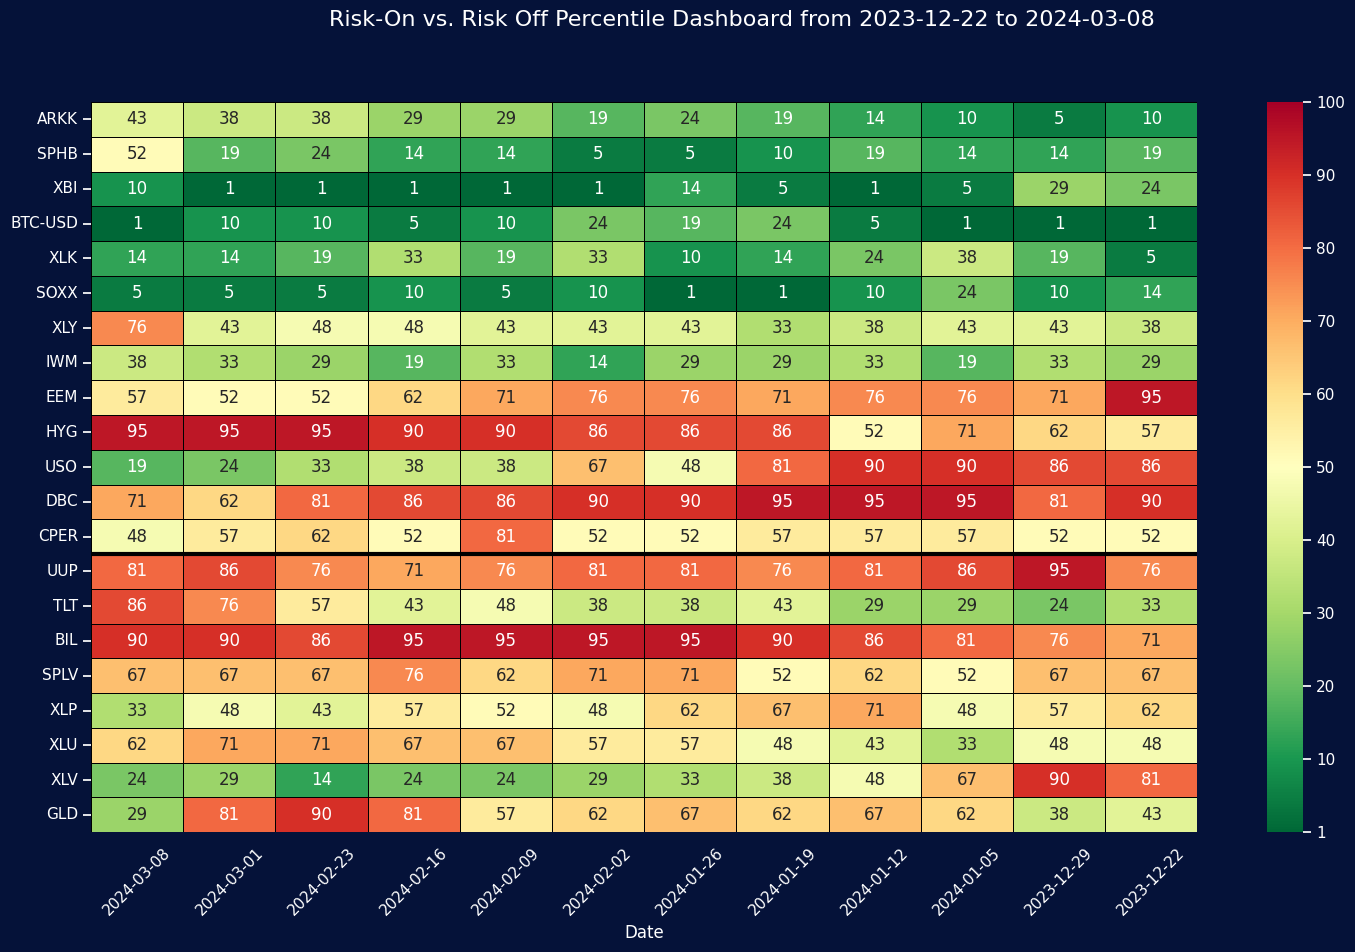

In [3]:
start_date = '2013-12-31'
end_date = '2024-03-08'
frequency = 'W'

risk_tickers = [
    'ARKK', 'SPHB', 'BTC-USD.CC', 'XBI', 'XLK', 'SOXX', 'XLY', 'IWM', 'EEM', 'HYG', 'USO', 'DBC', 'CPER',
]

safe_tickers = [
    'UUP', 'TLT', 'BIL', 'SPLV', 'XLP', 'XLU', 'XLV', 'GLD',
]


all_tickers = [
    'ARKK', 'SPHB', 'XBI', 'BTC-USD', 'XLK', 'SOXX', 'XLY', 'IWM', 'EEM', 'HYG', 'USO', 'DBC', 'CPER', 'UUP',
    'TLT', 'BIL', 'SPLV', 'XLP', 'XLU', 'XLV', 'GLD',
]

# create the scaled returns
df_scaled_returns = scale_multiple_tickers_by_volatility(all_tickers, start_date, end_date, window=12, frequency='W',
                                                         annualize=True, relative='SPY').dropna()

df_scaled_returns_filtered = reverse_column_order(df_scaled_returns.T, 12)

# Calculate percentiles
percentile_ranks = df_scaled_returns_filtered.apply(calculate_percentiles, axis=0)

# plot_heatmap(df_scaled_returns)
trend_scores = calculate_trend_scores(percentile_ranks)
plot_percentile_heatmap(percentile_ranks, end_date)

Create the technical indicators for all tickers.
We will store the results in a dictionary.
We will work with the all_indicators_std dictionary as it contains the standardized values.

In [7]:
all_indicators = calculate_technical_indicators(all_tickers, start_date, end_date, standardize=False)
all_indicators_std = calculate_technical_indicators(all_tickers, start_date, end_date, standardize=True)

# note: while we produced two dictionaries, one with standardization and one without
# we will work with the one that is standardized.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

You can examine the dicitonary to see its structure.
Each key is a ticker, and the value is a datafrme containing the entire time series of an indicator for that ticker.

In [6]:
# show an example
display(all_indicators_std['ARKK'])

,ADX_14,adx_diff,MACD_hist,rolling_vol_12,RSI,BBP_20_2.0,CMF,PPO_hist,rolling_dd_12,mass_index_25,scaled_returns_12
Date,,,,,,,,,,,
2015-11-27,-0.930962,0.102689,0.084349,-0.683866,0.060533,0.574492,-1.818195,0.101032,-0.060907,-1.774321,0.265853
2015-12-04,-0.963482,-0.032163,0.106442,-0.719836,-0.059169,0.472298,-1.818195,0.213429,-0.179833,-1.767781,-0.069895
2015-12-11,-1.004954,-0.119246,0.108162,-0.723555,-0.136093,0.459588,-1.930318,0.258995,-0.252846,-1.750617,-0.237452
2015-12-18,-1.048562,-0.160979,0.104391,-0.922925,-0.130757,0.553239,-1.543774,0.435441,-0.457447,-1.701726,0.256014
2015-12-25,-1.088851,-0.161831,0.093882,-0.957422,-0.163492,0.480800,-1.573570,0.597789,-0.244417,-1.634449,0.622815
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-09,-0.578372,0.296404,0.046984,-0.336062,0.286186,0.408644,1.371261,1.678354,-0.163969,-0.422172,0.366166
2024-02-16,-0.545655,0.497463,0.108917,-0.347983,0.373401,0.437315,1.318532,1.355679,-0.163969,-0.385744,0.293572
2024-02-23,-0.568550,0.162560,0.026433,-0.529454,0.044483,0.115614,1.014805,0.871953,-0.311395,-0.348536,-0.415706


Now that we have our data, we can create the DTW functions. We will create two functions:
1) Function 1 will calculate the DTW for each pair for a given indicator
2) Function 2 will loop through each indicator and call function 1.

In [8]:
def calculate_dtw_for_indicator(all_indicators, indicator):
    """
    Calculate each pairwise DTW using Parallel processing for a given technical indicator.

    Parameters:
    all_indicators (dict): Dictionary with technical indicator DataFrames.
    indicator (str): Name of the technical indicator to use.

    Returns:
    DataFrame: DataFrame with DTW distances for the specified technical indicator.
    """
    # Extract the specified technical indicator from the dictionary
    indicator_df = extract_indicator_from_dict(all_indicators, indicator).dropna()
    assets = indicator_df.columns
    pairs = list(combinations(assets, 2))

    def single_pair_dtw(pair):
        return dtw.distance(indicator_df[pair[0]], indicator_df[pair[1]])

    # calculate the DTW for each pair
    dtw_distances = Parallel(n_jobs=-1)(delayed(single_pair_dtw)(pair) for pair in pairs)
    dtw_matrix = pd.DataFrame(index=assets, columns=assets)

    for i, pair in enumerate(pairs):
        dtw_matrix.at[pair[0], pair[1]] = dtw_distances[i]
        dtw_matrix.at[pair[1], pair[0]] = dtw_distances[i]  # Symmetric

    # Replace the diagonal with 0
    np.fill_diagonal(dtw_matrix.values, 0)

    return dtw_matrix.astype(float)


def calculate_all_technicals_dtw(all_indicators):
    """
    Calculate DTW for each technical indicator and store the resulting DataFrames in a dictionary.

    Parameters:
    all_indicators (dict): Dictionary with technical indicator DataFrames.
    standardize (bool): Whether to standardize the time series history of the technical indicators.

    Returns:
    dict: Dictionary with DTW DataFrames for each technical indicator.
    """
    # Initialize an empty dictionary to store the DTW DataFrames
    dtw_dict = {}

    # Loop through each technical indicator and calculate the DTW
    for indicator in all_indicators[list(all_indicators.keys())[0]].columns:
        # Calculate the DTW for the specified technical indicator
        dtw_matrix = calculate_dtw_for_indicator(all_indicators, indicator)

        # Store the DataFrame in the dictionary
        dtw_dict[indicator] = dtw_matrix

    return dtw_dict

Now executing this next cell could take a while! Go grab a coffee. We will also store the resulting dictionary as a pkl file so that we can retrieve it easily if needed.
Note that storing files in a colab instance is available only in this instance! Downloading the pkl file is highly recommened! And then you can upload it every time you work on this notebook.



In [9]:
techincals_dtw_dict = calculate_all_technicals_dtw(all_indicators_std)
export_as_pickle(techincals_dtw_dict, 'techincals_dtw_dict_2024-03-08.pkl')

File saved as techincals_dtw_dict_2024-03-08.pkl


# Clustering Algorithm Part (should be the fun part, but no promises)

Now that we have our distances data, we can do some clustering. Following the game plan in the Medium article, we will start with K-Medoids with 2 clusters.

First let's declare two functions:

1.   One with a simple clustering algorithm where we can select the target number of clusters.
2.   The second function will perform some feature selection where we can remove some features (technical indicators) if they do not help explain any of the variance.


In [16]:
def kmedoids_on_dtw(technicals_dtw_dict, n_clusters):
    """
    Clusters tickers based on their average pairwise distances across multiple technical indicators,
    avoiding self-distances and double-counting, using K-Medoids clustering algorithm.

    Parameters:
    - technicals_dtw_dict (dict): A dictionary where keys are technical indicator names and values
      are pandas DataFrames or numpy arrays representing the pairwise distance matrix for each indicator.
    - n_clusters (int): The number of clusters to form.

    Returns:
    - cluster_assignments_df (pandas DataFrame): A DataFrame with two columns, 'Ticker' and 'Cluster',
      where each row represents a ticker and its assigned cluster label.

    The function calculates the average distance for each ticker to all others for each technical indicator,
    excluding self-distances and avoiding double-counting by using only the upper triangle of the symmetric
    distance matrices. These averages serve as features in a feature matrix used for K-Medoids clustering.
    The resulting DataFrame maps each ticker to a cluster label determined by K-Medoids based on the tickers'
    dissimilarity profiles across the selected technical indicators.
    """

    # Initialize MDS model
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)

    # Calculate the average distance for each ticker, excluding self-distances and avoiding double-counting
    avg_distances = {}
    for indicator, dist_matrix in technicals_dtw_dict.items():
        # Convert to numpy array if it's a DataFrame
        dist_matrix_np = dist_matrix.values if hasattr(dist_matrix, 'values') else dist_matrix

        # Initialize an empty array to store average distances for this indicator
        avg_dist_array = np.zeros(dist_matrix_np.shape[0])

        for i in range(dist_matrix_np.shape[0]):
            # Use indices to get the upper triangle for each row, excluding the diagonal
            upper_triangle_indices = np.triu_indices_from(dist_matrix_np[i:i + 1, :], k=1)

            # Calculate the average distance for the ticker, using only the upper triangle part of its row
            avg_dist_array[i] = np.mean(dist_matrix_np[i, upper_triangle_indices[1]])

        # Fill the avg_distances dictionary with the average distances for this indicator
        avg_distances[indicator] = pd.Series(avg_dist_array, index=dist_matrix.index)

    # Convert the avg_distances dictionary to a DataFrame to use as the feature matrix
    feature_matrix = pd.DataFrame(avg_distances)

    # Initialize K-Medoids with the specified number of clusters
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)

    # Fit K-Medoids directly to the feature_matrix
    kmedoids.fit(feature_matrix)

    # Retrieve the cluster labels
    labels = kmedoids.labels_

    # Get the tickers
    tickers = feature_matrix.index.tolist()

    # Create a DataFrame mapping tickers to cluster labels
    cluster_assignments_df = pd.DataFrame({
        'Ticker': tickers,
        'Cluster': labels
    })

    # Return the DataFrame
    return cluster_assignments_df


def kmedoids_with_feature_selection(technicals_dtw_dict, initial_n_clusters, final_n_clusters,
                                    n_features_to_select):
    """
    Clusters tickers based on technical indicators' pairwise distances, applies feature selection
    via RFE to identify the most informative indicators, and then performs final clustering.

    Parameters:
    - technicals_dtw_dict (dict): Dictionary with technical indicator names as keys and distance matrices as values.
    - initial_n_clusters (int): Number of clusters for initial clustering.
    - final_n_clusters (int): Number of clusters for final clustering after feature selection.
    - n_features_to_select (int): Number of features to select with RFE.

    Returns: - final_cluster_assignments_df (DataFrame): DataFrame mapping each ticker to its final cluster label
    after feature selection.
    """

    # Initialize MDS model
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)

    # Calculate the average distance for each ticker, excluding self-distances and avoiding double-counting
    avg_distances = {}
    for indicator, dist_matrix in technicals_dtw_dict.items():
        dist_matrix_np = dist_matrix.values if hasattr(dist_matrix, 'values') else dist_matrix
        avg_dist_array = np.zeros(dist_matrix_np.shape[0])
        for i in range(dist_matrix_np.shape[0]):
            upper_triangle_indices = np.triu_indices_from(dist_matrix_np[i:i + 1, :], k=1)
            avg_dist_array[i] = np.mean(dist_matrix_np[i, upper_triangle_indices[1]])
        avg_distances[indicator] = pd.Series(avg_dist_array, index=dist_matrix.index)

    # Convert the avg_distances dictionary to a DataFrame to use as the feature matrix
    feature_matrix = pd.DataFrame(avg_distances)

    # Initial Clustering with K-Medoids
    kmedoids_prelim = KMedoids(n_clusters=initial_n_clusters, random_state=42)
    kmedoids_prelim.fit(feature_matrix)
    initial_labels = kmedoids_prelim.labels_

    # Feature Selection with RFE
    classifier = RandomForestClassifier(random_state=42)
    rfe = RFE(estimator=classifier, n_features_to_select=n_features_to_select)
    rfe.fit(feature_matrix, initial_labels)
    selected_feature_names = feature_matrix.columns[rfe.support_]
    print("Selected Features:", selected_feature_names.tolist())

    # Final Clustering with Selected Features
    selected_features_matrix = feature_matrix[selected_feature_names]
    kmedoids_final = KMedoids(n_clusters=final_n_clusters, random_state=42)
    kmedoids_final.fit(selected_features_matrix)
    final_labels = kmedoids_final.labels_

    # Mapping and Comparison
    tickers = feature_matrix.index.tolist()
    final_cluster_assignments_df = pd.DataFrame({'Ticker': tickers, 'Cluster': final_labels})
    print(final_cluster_assignments_df)

    cluster_comparison_df = pd.DataFrame(
        {'Ticker': tickers, 'Initial Cluster': initial_labels, 'Final Cluster': final_labels})
    print(cluster_comparison_df)

    # Adjusted Rand Index
    ari_score = adjusted_rand_score(initial_labels, final_labels)
    print(f"Adjusted Rand Index: {ari_score}")

    return final_cluster_assignments_df

In [17]:
# load the pkl file if you are coming back into the file and do not want to wait on recreating the DTW matrices.
technicals_dtw_dict = load_from_pickle('techincals_dtw_dict_2024-03-08.pkl')

# perform clustering, with 2 clusters, no feature selection.

cluster_df = kmedoids_on_dtw(technicals_dtw_dict, 2)
display(cluster_df)

,Ticker,Cluster
0,ARKK,1
1,SPHB,0
2,XBI,1
3,BTC-USD,1
4,XLK,0
5,SOXX,0
6,XLY,0
7,IWM,0
8,EEM,0
9,HYG,0


The initial results without and feature selection with 2 clusters is not that good. I can say this because we know empirically that high beta (SPHB) should be in the same cluster as ARKK and XBI. Those are all very risky high beta investments!

And then you can see that many of the risk-off ETFs are coming in as risky. So this is pretty bad.

Let's try it now with feature selection (we will keep 5) and 2 clusters.

In [18]:
technicals_dtw_dict = load_from_pickle('techincals_dtw_dict_2024-03-08.pkl')
cluster_2_df = kmedoids_with_feature_selection(technicals_dtw_dict, initial_n_clusters=2, final_n_clusters=2,
                                    n_features_to_select=5)

Selected Features: ['rolling_vol_12', 'BBP_20_2.0', 'PPO_hist', 'rolling_dd_12', 'mass_index_25']
     Ticker  Cluster
0      ARKK        0
1      SPHB        1
2       XBI        0
3   BTC-USD        0
4       XLK        1
5      SOXX        1
6       XLY        1
7       IWM        1
8       EEM        1
9       HYG        1
10      USO        0
11      DBC        0
12     CPER        0
13      UUP        0
14      TLT        0
15      BIL        0
16     SPLV        1
17      XLP        1
18      XLU        1
19      XLV        1
20      GLD        0
     Ticker  Initial Cluster  Final Cluster
0      ARKK                1              0
1      SPHB                0              1
2       XBI                1              0
3   BTC-USD                1              0
4       XLK                0              1
5      SOXX                0              1
6       XLY                0              1
7       IWM                0              1
8       EEM                0              1


The results are not much better. In fact, it didn't do anything.
Disappointing, but I never expect my first attempts to yield great results. That would be too easy.

Let's repeat the above two cells using 3 clusters and see if it is any better.

In [19]:
technicals_dtw_dict = load_from_pickle('techincals_dtw_dict_2024-03-08.pkl')
cluster_df = kmedoids_on_dtw(technicals_dtw_dict, 3)
display(cluster_df)

,Ticker,Cluster
0,ARKK,2
1,SPHB,2
2,XBI,2
3,BTC-USD,1
4,XLK,0
5,SOXX,2
6,XLY,0
7,IWM,2
8,EEM,2
9,HYG,0


ok, this is getting a little better. I don't like that TLT is grouped with the commodities and that GLD is risky, but the rest looks pretty good.
Let's add feature selection.

In [20]:
technicals_dtw_dict = load_from_pickle('techincals_dtw_dict_2024-03-08.pkl')
cluster_3_df = kmedoids_with_feature_selection(technicals_dtw_dict, 3, 3, 5)

Selected Features: ['ADX_14', 'adx_diff', 'RSI', 'BBP_20_2.0', 'scaled_returns_12']
     Ticker  Cluster
0      ARKK        1
1      SPHB        1
2       XBI        1
3   BTC-USD        2
4       XLK        0
5      SOXX        1
6       XLY        0
7       IWM        1
8       EEM        1
9       HYG        0
10      USO        0
11      DBC        0
12     CPER        0
13      UUP        2
14      TLT        2
15      BIL        2
16     SPLV        1
17      XLP        0
18      XLU        2
19      XLV        2
20      GLD        2
     Ticker  Initial Cluster  Final Cluster
0      ARKK                2              1
1      SPHB                2              1
2       XBI                2              1
3   BTC-USD                1              2
4       XLK                0              0
5      SOXX                2              1
6       XLY                0              0
7       IWM                2              1
8       EEM                2              1
9       HYG   

This looks a lot better! Except for BTC being a risk-off asset. But BTC would likely be removed from clustering. It could stay on the dashboard, but here, I think it is just confusing things.

Also SPLV is in the wrong group.

Not perfect, but it's a good start. This was about process; not finding the best model.